In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input -- Share number uncertain before 2013
## Hardcoded block

In [2]:
evaluate_last_X_years = True
X=10
currency_pair = 'NOK=X'
numbers_in_currency = 'NOK'
share_name = 'GSF.OL'

# 1.2. Raw input statement data

In [3]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date', 'real_date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [4]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [5]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares,real_date
0,2014-09-30,956,-467,488,-59,196,396,92,2328,108,...,433,304,0,864,1371,2804,186,-77,112.0,2014-11-14
1,2014-12-31,990,-513,478,207,181,504,91,2714,109,...,360,736,0,1328,1219,3130,-186,-163,112.0,2015-02-14
2,2015-03-31,1023,-598,426,-51,201,394,93,2609,109,...,340,717,0,1286,1280,3138,119,-120,112.0,2015-05-15
3,2015-06-30,1149,-835,314,-101,240,582,89,2674,109,...,549,840,0,1583,1231,3372,85,-45,112.0,2015-08-14
4,2015-09-30,1246,-575,671,6,309,442,102,2708,110,...,515,742,0,1493,1328,3399,176,-76,112.0,2015-11-14


## Calculate date when quaterly reports could be available

In [6]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [7]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
36,2023-09-30,2023-11-14,112.00,1164,-383,781,148,286,203,202,...,1534,13076,759,0,443,2199,3606,6915,-380,-145
37,2023-12-31,2024-02-14,113.00,1937,-995,942,247,216,327,230,...,1502,13663,760,0,508,1776,4603,7294,-728,-186
38,2024-03-31,2024-05-13,113.45,2289,-1061,1228,-330,279,316,180,...,1527,13101,665,0,450,1372,4448,6716,688,-239
39,2024-06-30,2024-08-19,113.45,1520,-644,908,-700,365,285,223,...,1503,13076,809,0,1906,2980,3815,7617,-76,-291
40,2024-09-30,2024-11-25,113.45,1460,-708,752,-31,155,110,260,...,1499,13815,1219,0,1899,3437,4055,8384,50,-332


## Pull historical average USD national currency rates and add to the dataframe

In [8]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-11-14,112.00,1164,-383,781,148,286,203,202,...,13076,759,0,443,2199,3606,6915,-380,-145,10.483742
37,2023-12-31,2024-02-14,113.00,1937,-995,942,247,216,327,230,...,13663,760,0,508,1776,4603,7294,-728,-186,10.821103
38,2024-03-31,2024-05-13,113.45,2289,-1061,1228,-330,279,316,180,...,13101,665,0,450,1372,4448,6716,688,-239,10.502364
39,2024-06-30,2024-08-19,113.45,1520,-644,908,-700,365,285,223,...,13076,809,0,1906,2980,3815,7617,-76,-291,10.750878
40,2024-09-30,2024-11-25,113.45,1460,-708,752,-31,155,110,260,...,13815,1219,0,1899,3437,4055,8384,50,-332,10.704589


## Convert USD values related to IS, BS, CFS to national currency

In [9]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
36,2023-09-30,2023-11-14,112.00,1164,-383,781,148,286,203,202,...,13076,759,0,443,2199,3606,6915,-380,-145,10.483742
37,2023-12-31,2024-02-14,113.00,1937,-995,942,247,216,327,230,...,13663,760,0,508,1776,4603,7294,-728,-186,10.821103
38,2024-03-31,2024-05-13,113.45,2289,-1061,1228,-330,279,316,180,...,13101,665,0,450,1372,4448,6716,688,-239,10.502364
39,2024-06-30,2024-08-19,113.45,1520,-644,908,-700,365,285,223,...,13076,809,0,1906,2980,3815,7617,-76,-291,10.750878
40,2024-09-30,2024-11-25,113.45,1460,-708,752,-31,155,110,260,...,13815,1219,0,1899,3437,4055,8384,50,-332,10.704589


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [10]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [11]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [12]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [13]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2014-11-17,22.003759,2014-09-30,956.0,0.0,17.267857,112.0,0.0,0.0,196.0,...,0.408189,0.591811,0.0,0.0,0.0,0.0,0.51046,-0.061715,0.0,0.0
1,2014-11-24,21.174847,2014-09-30,956.0,0.0,17.267857,112.0,0.0,0.0,196.0,...,0.408189,0.591811,0.0,0.0,0.0,0.0,0.51046,-0.061715,0.0,0.0
2,2014-12-01,21.853045,2014-09-30,956.0,0.0,17.267857,112.0,0.0,0.0,196.0,...,0.408189,0.591811,0.0,0.0,0.0,0.0,0.51046,-0.061715,0.0,0.0
3,2014-12-08,19.893806,2014-09-30,956.0,0.0,17.267857,112.0,0.0,0.0,196.0,...,0.408189,0.591811,0.0,0.0,0.0,0.0,0.51046,-0.061715,0.0,0.0
4,2014-12-15,21.099493,2014-09-30,956.0,0.0,17.267857,112.0,0.0,0.0,196.0,...,0.408189,0.591811,0.0,0.0,0.0,0.0,0.51046,-0.061715,0.0,0.0


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [14]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2014-11-17,22.003759,2014-09-30,956.0,0.0,17.267857,112.0,0.0,0.0,196.0,...,0.0,0.51046,-0.061715,0.0,0.0,inf,1.274261,inf,inf,inf
1,2014-11-24,21.174847,2014-09-30,956.0,0.0,17.267857,112.0,0.0,0.0,196.0,...,0.0,0.51046,-0.061715,0.0,0.0,inf,1.226258,inf,inf,inf
2,2014-12-01,21.853045,2014-09-30,956.0,0.0,17.267857,112.0,0.0,0.0,196.0,...,0.0,0.51046,-0.061715,0.0,0.0,inf,1.265533,inf,inf,inf
3,2014-12-08,19.893806,2014-09-30,956.0,0.0,17.267857,112.0,0.0,0.0,196.0,...,0.0,0.51046,-0.061715,0.0,0.0,inf,1.152072,inf,inf,inf
4,2014-12-15,21.099493,2014-09-30,956.0,0.0,17.267857,112.0,0.0,0.0,196.0,...,0.0,0.51046,-0.061715,0.0,0.0,inf,1.221894,inf,inf,inf


# Calculate Dividend yield and currency-share price correlation

In [15]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

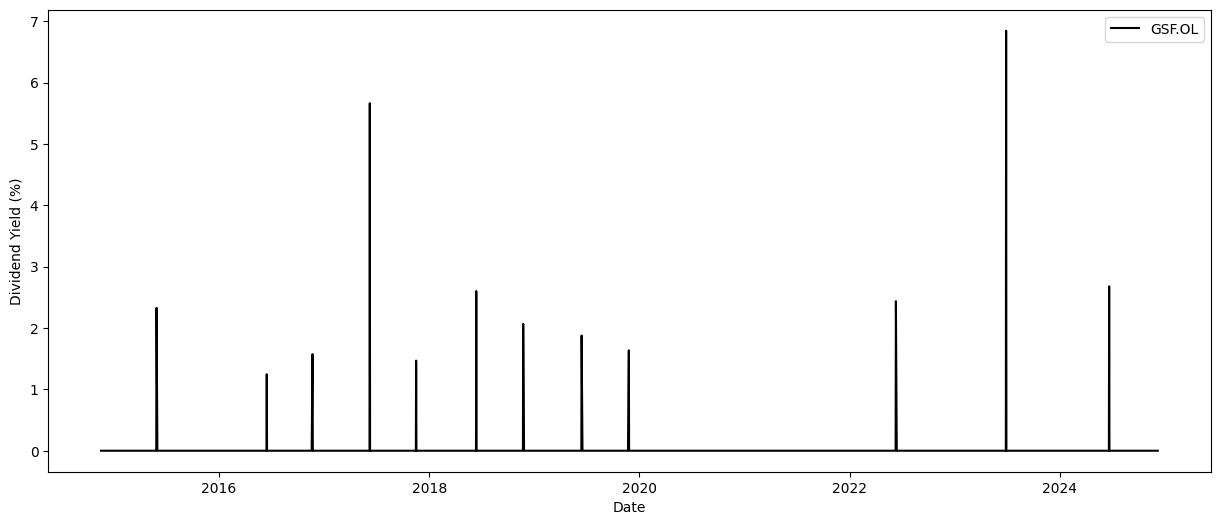

In [16]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.305019
share_price      1.000000
Name: share_price, dtype: float64


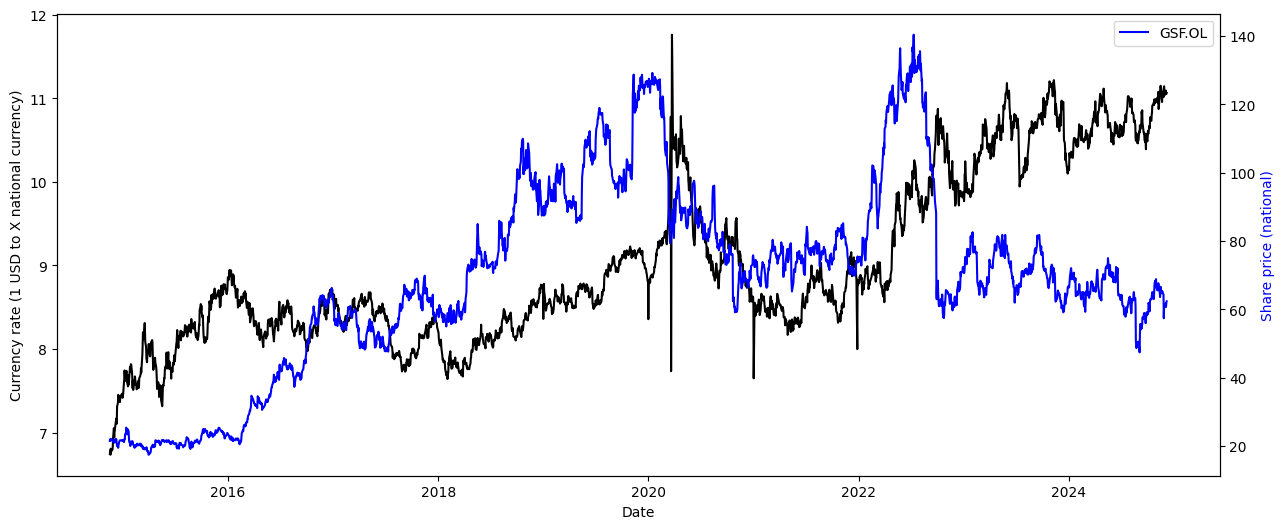

In [17]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

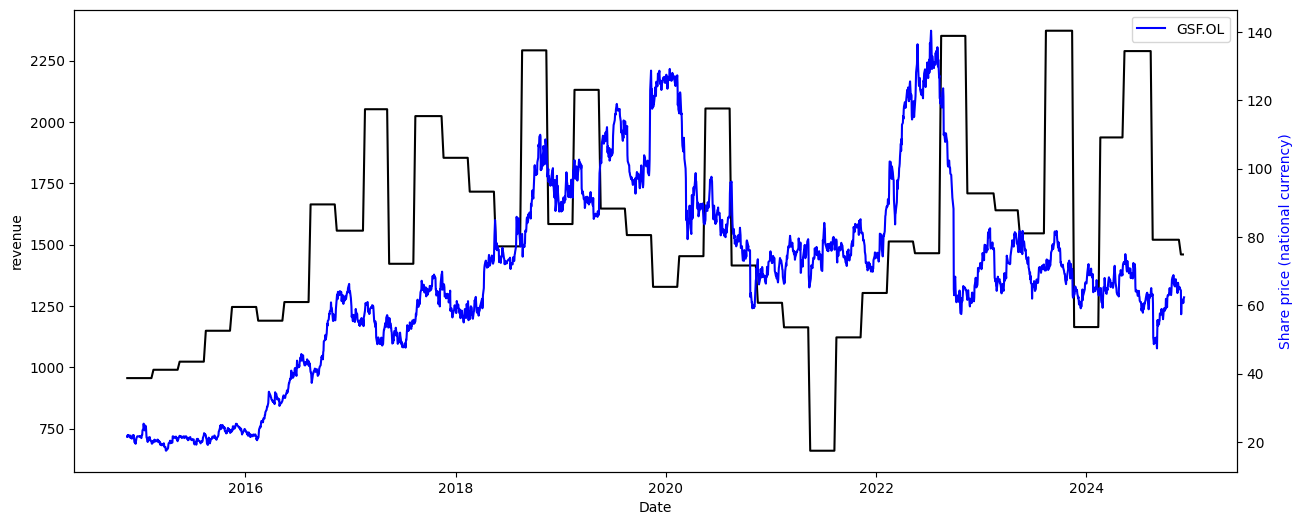

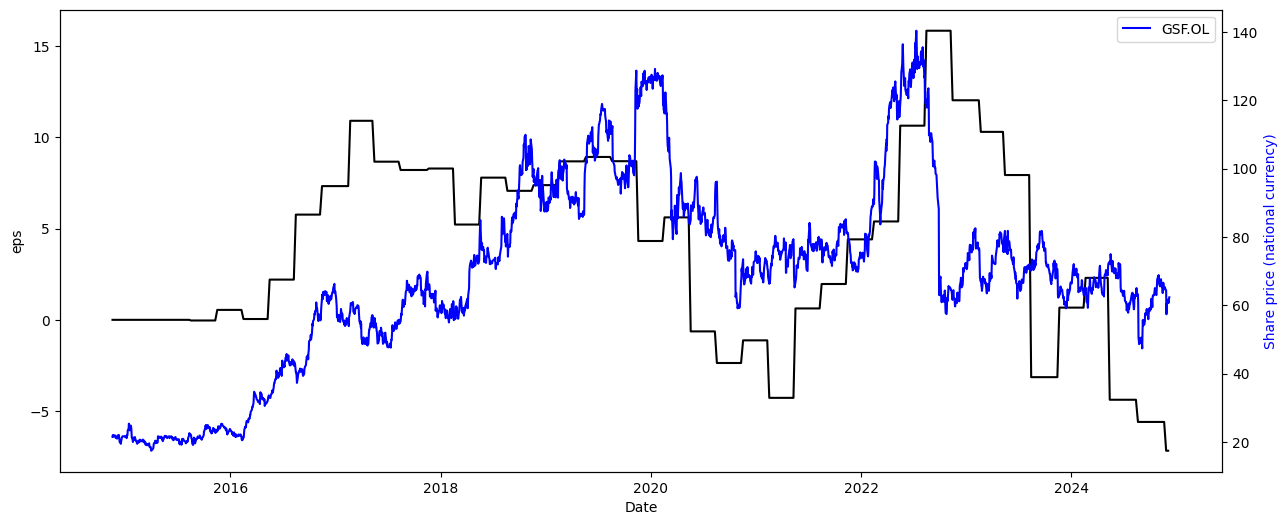

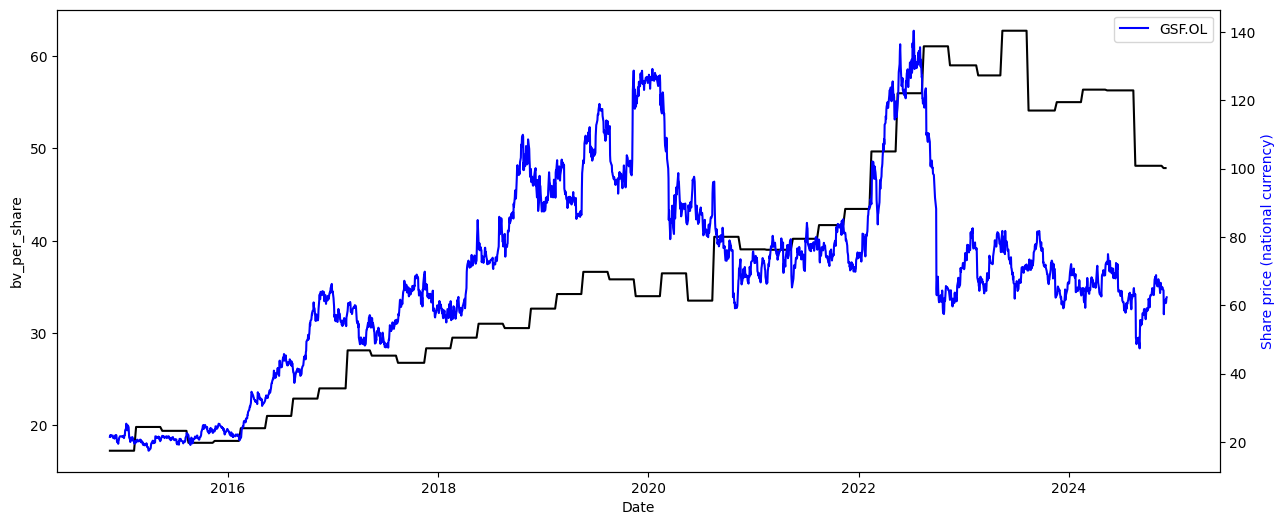

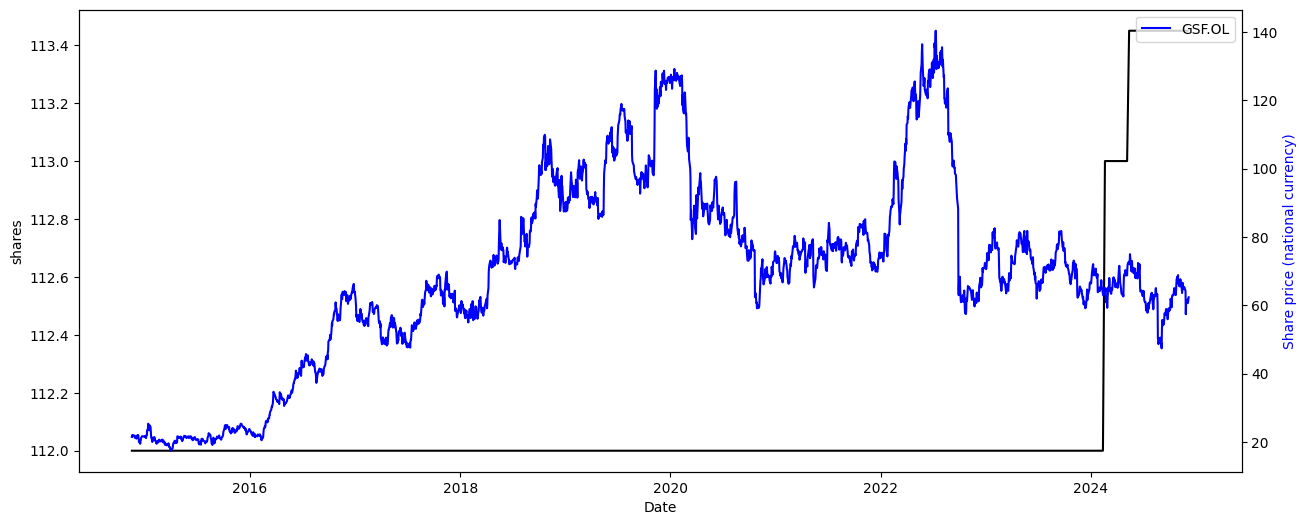

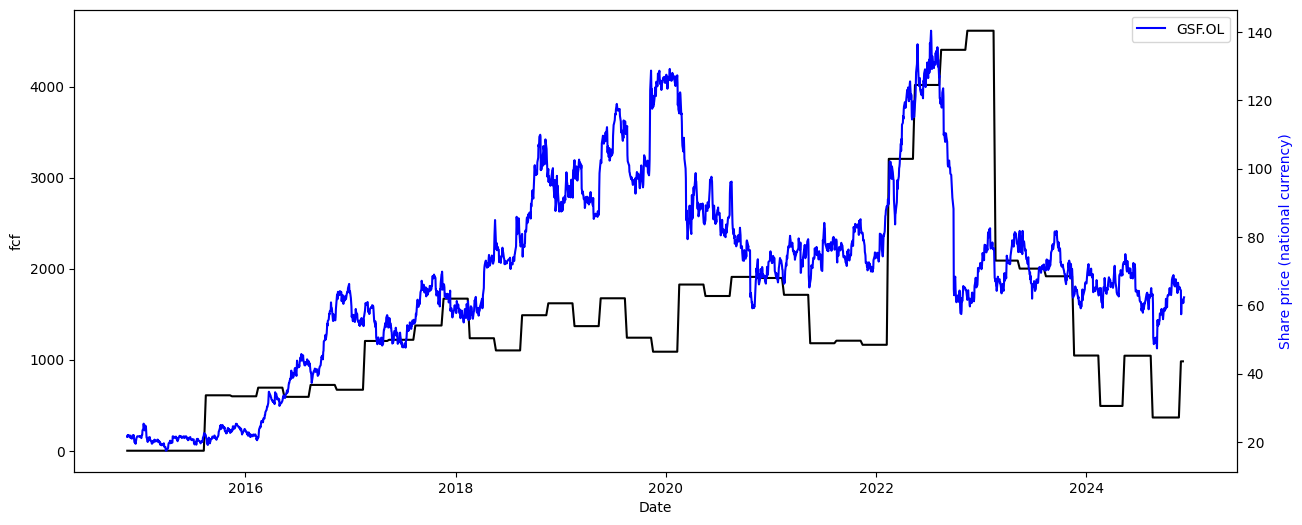

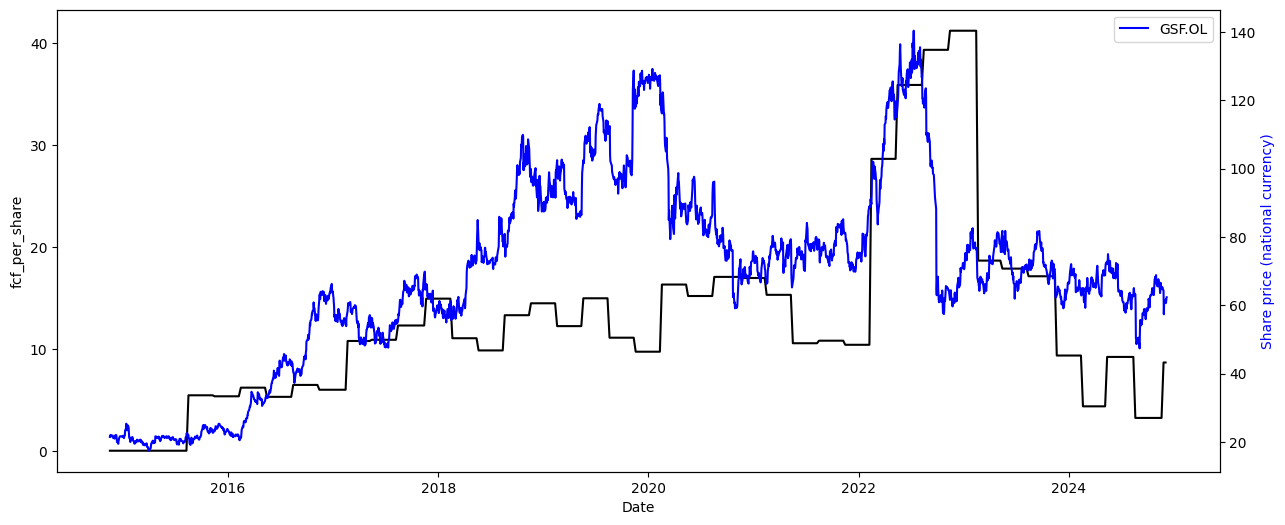

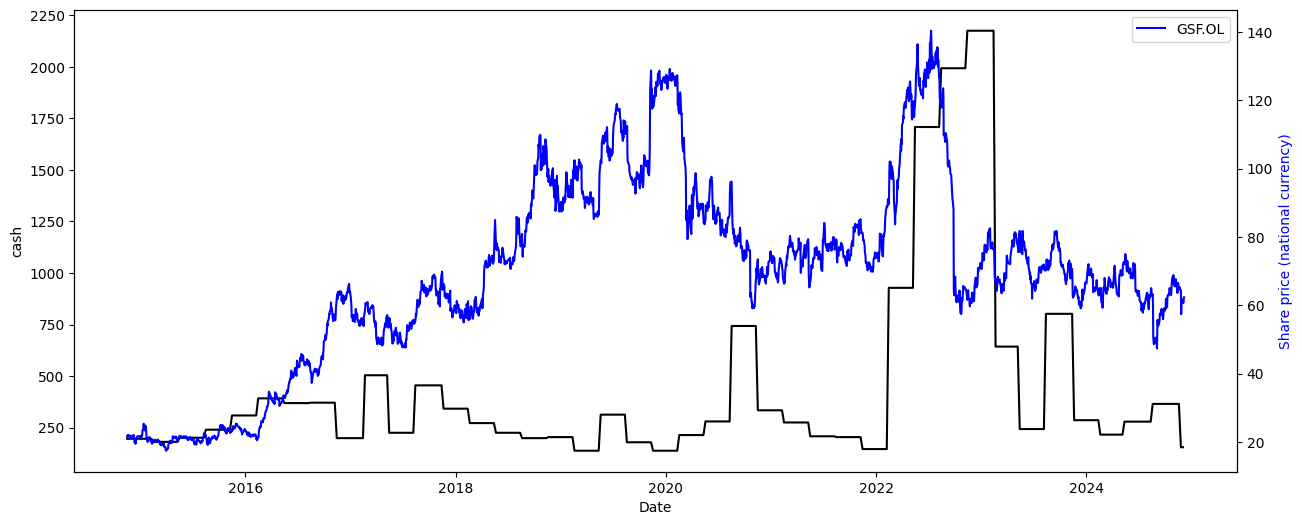

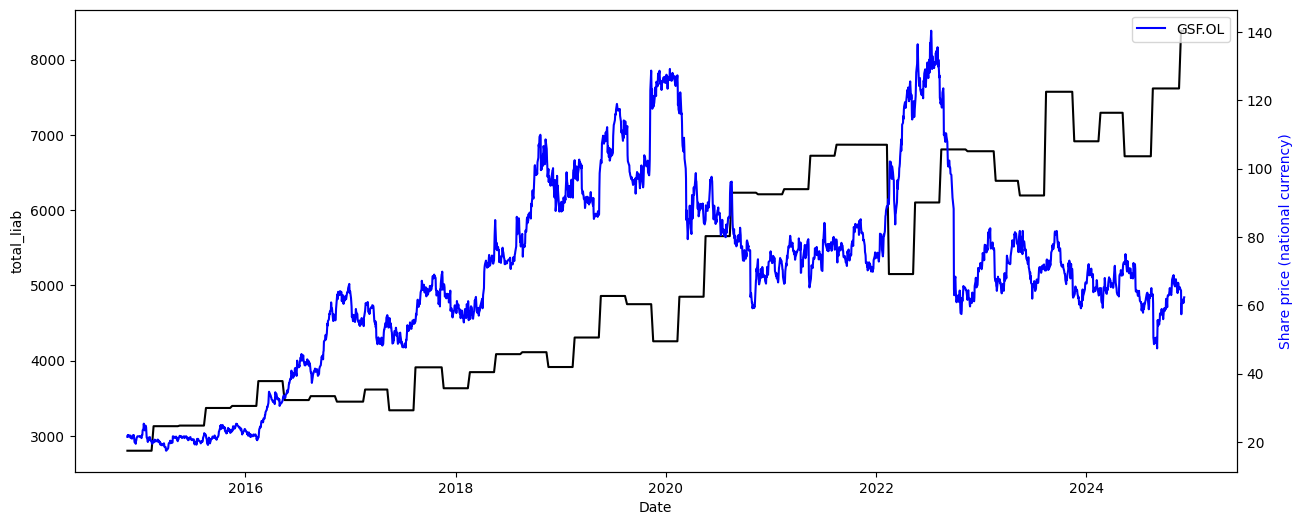

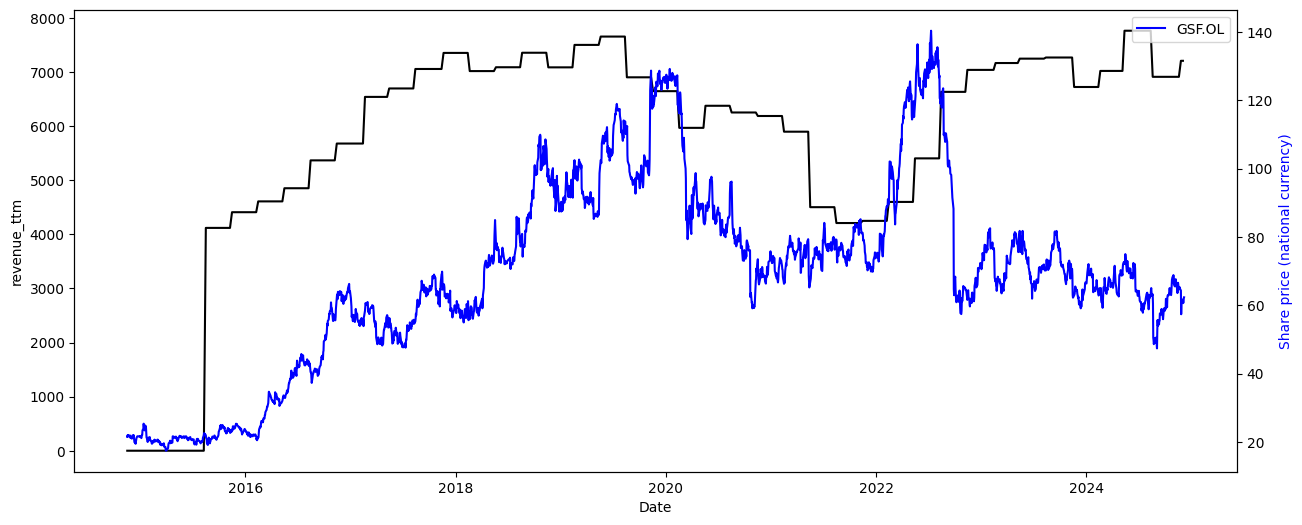

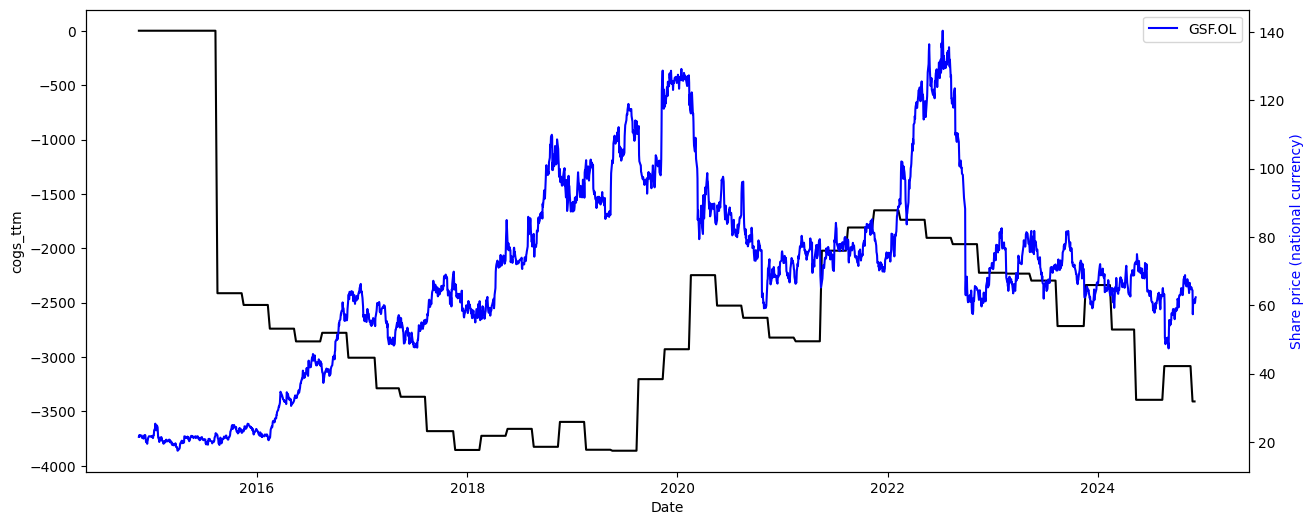

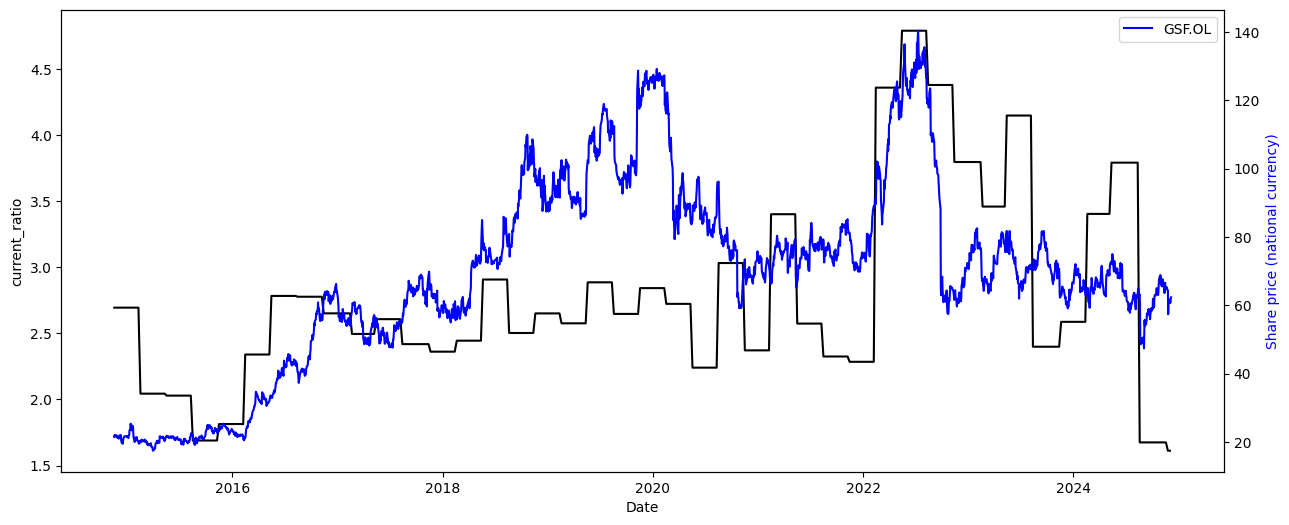

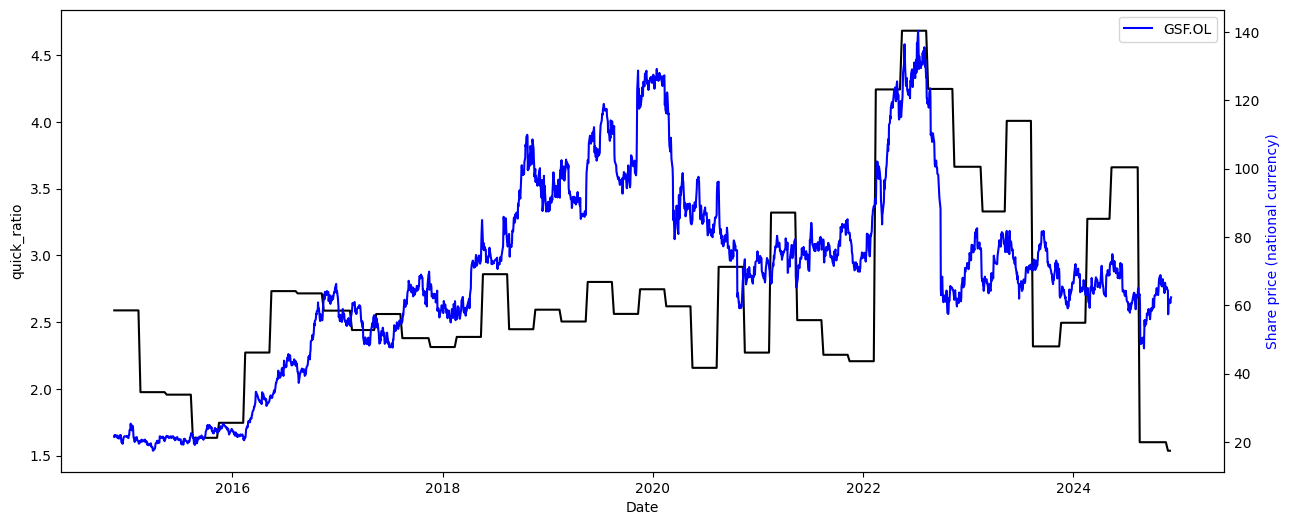

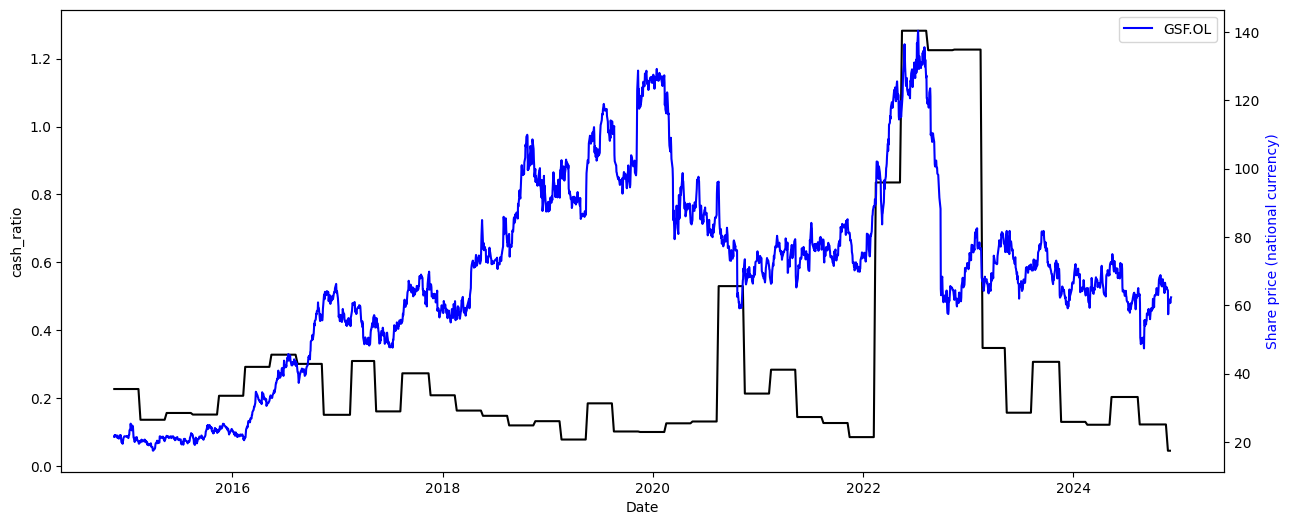

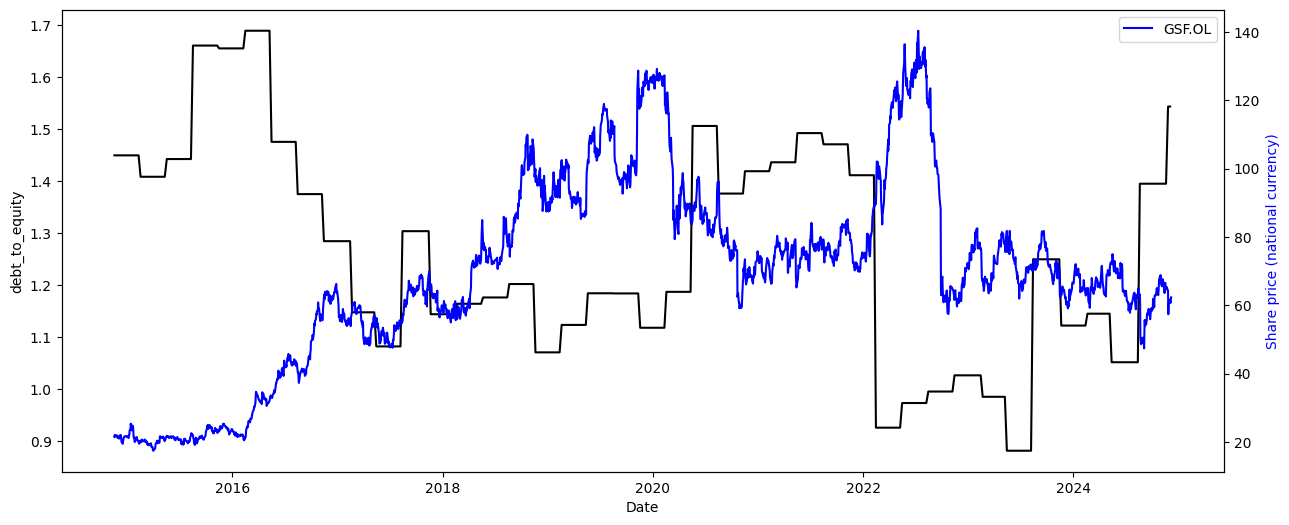

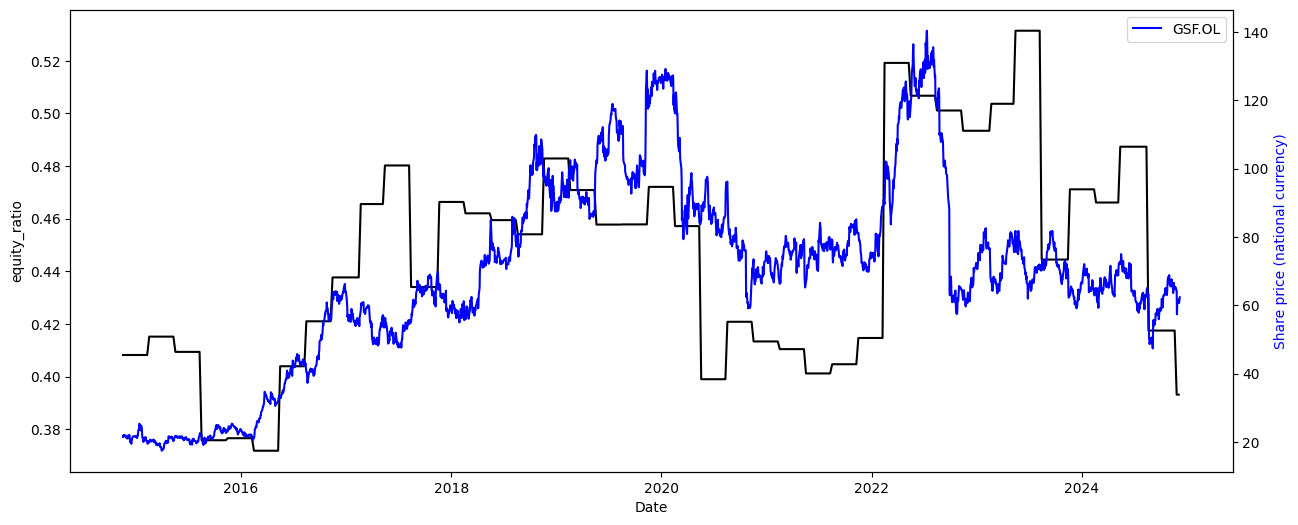

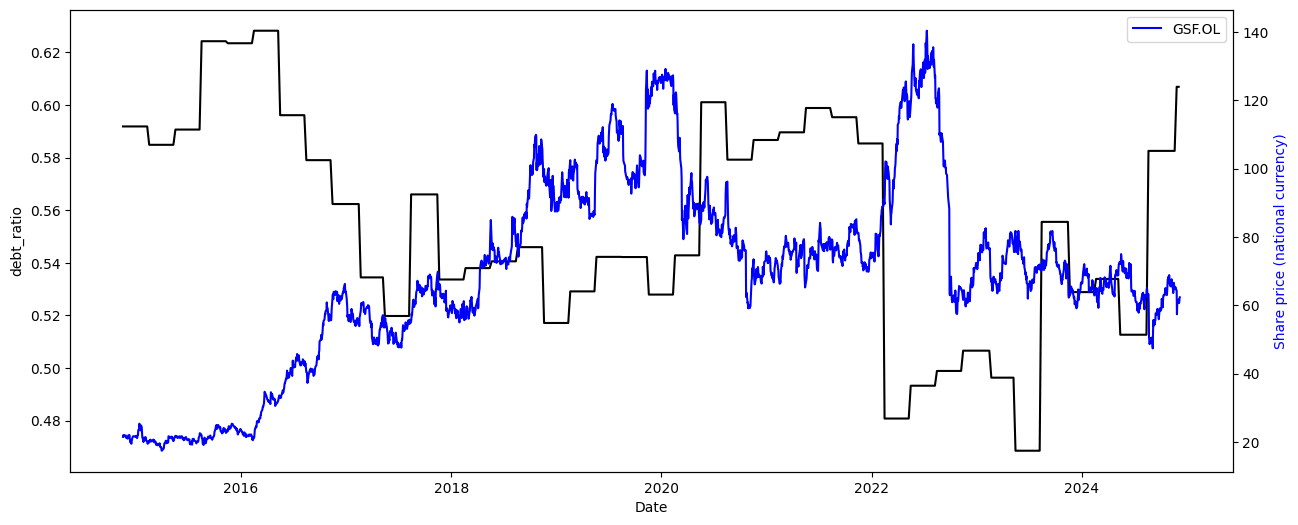

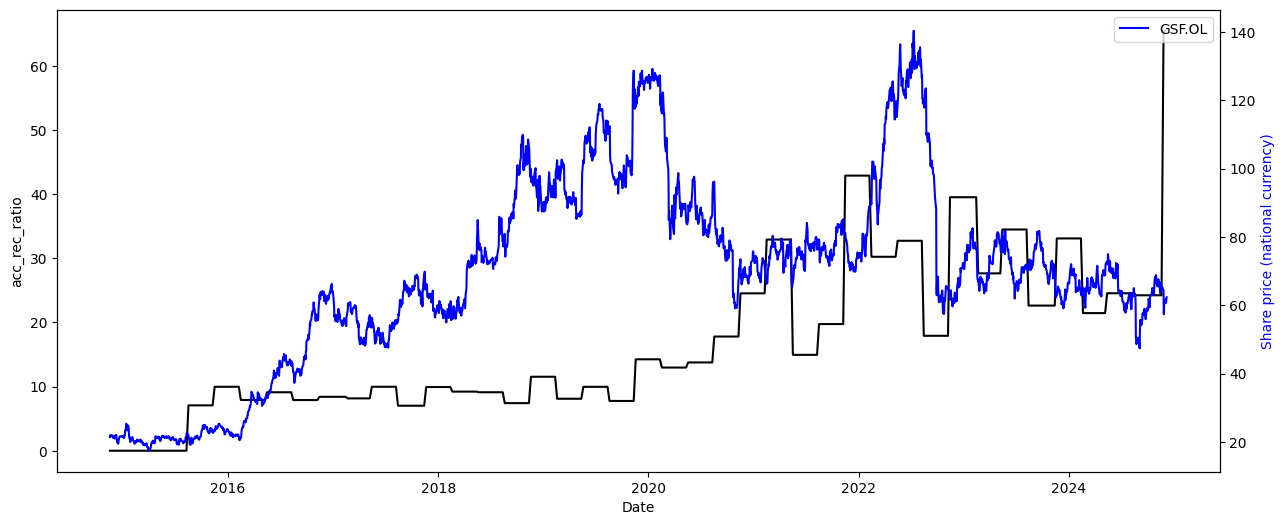

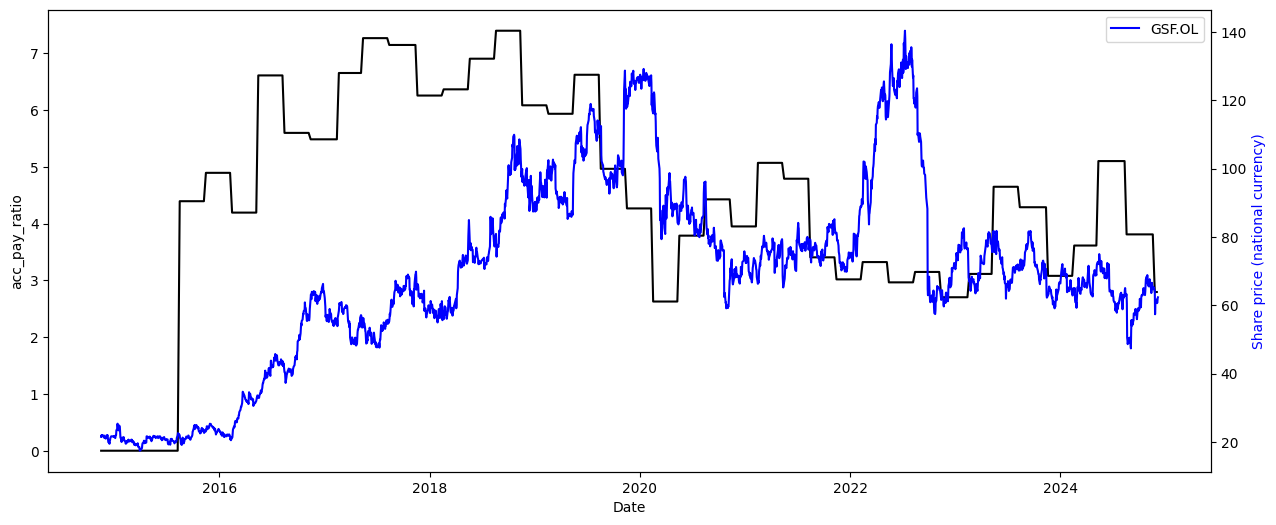

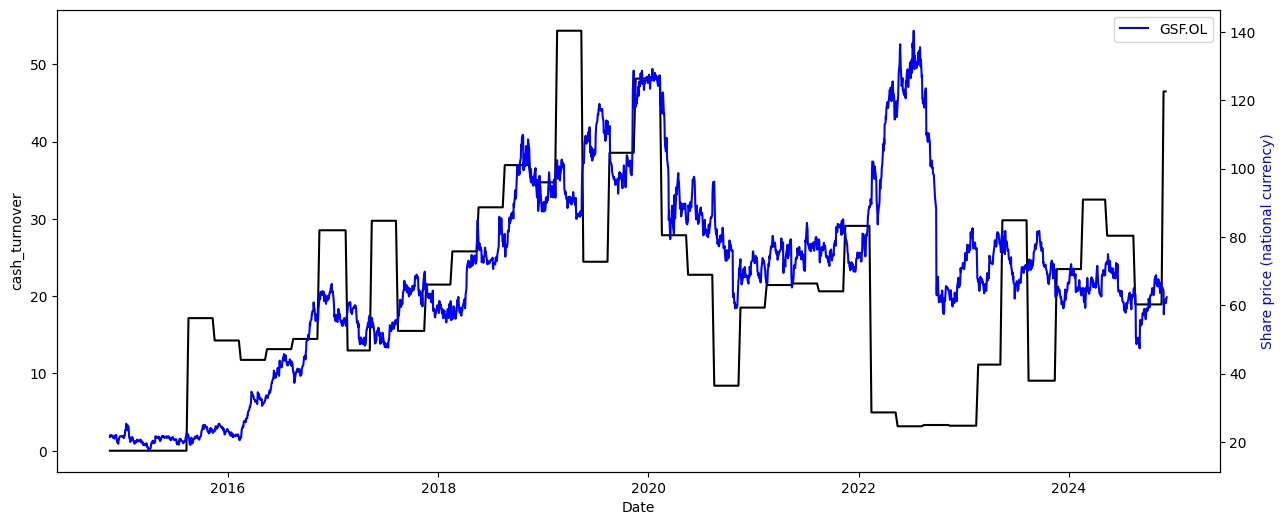

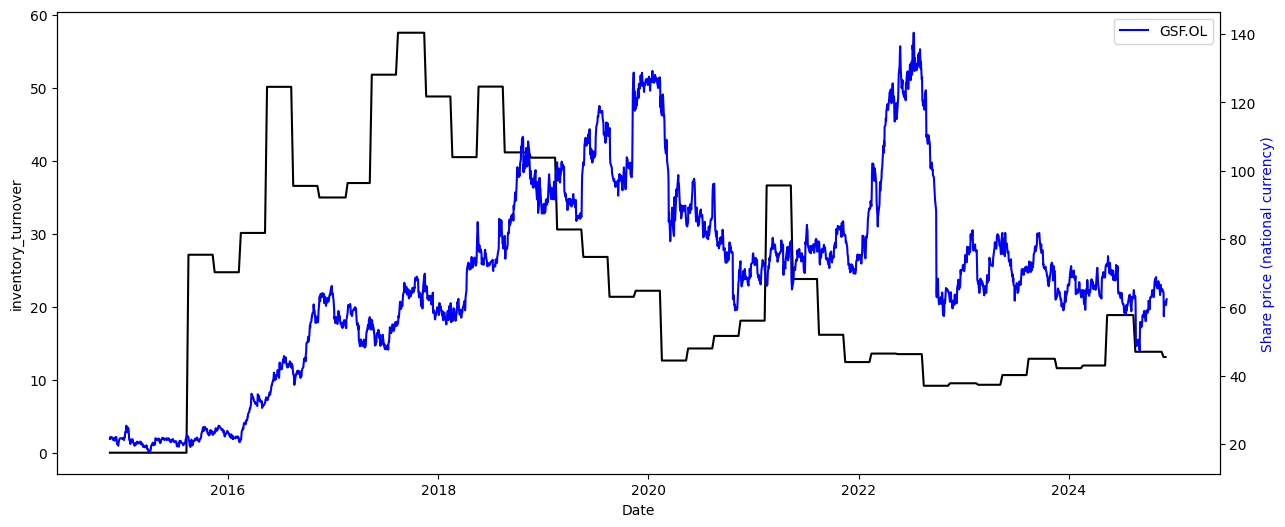

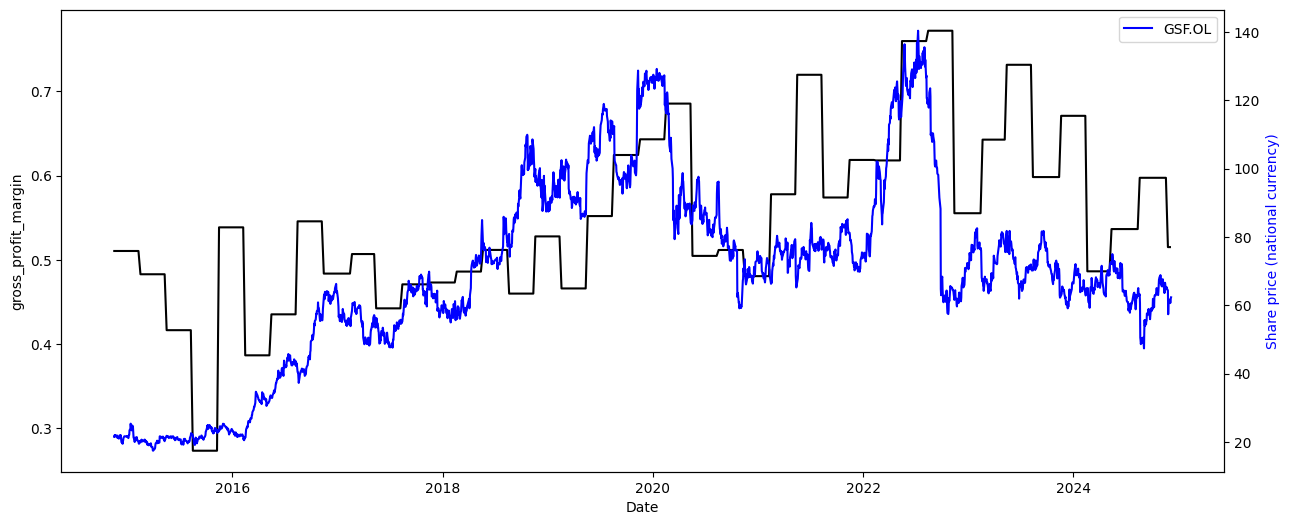

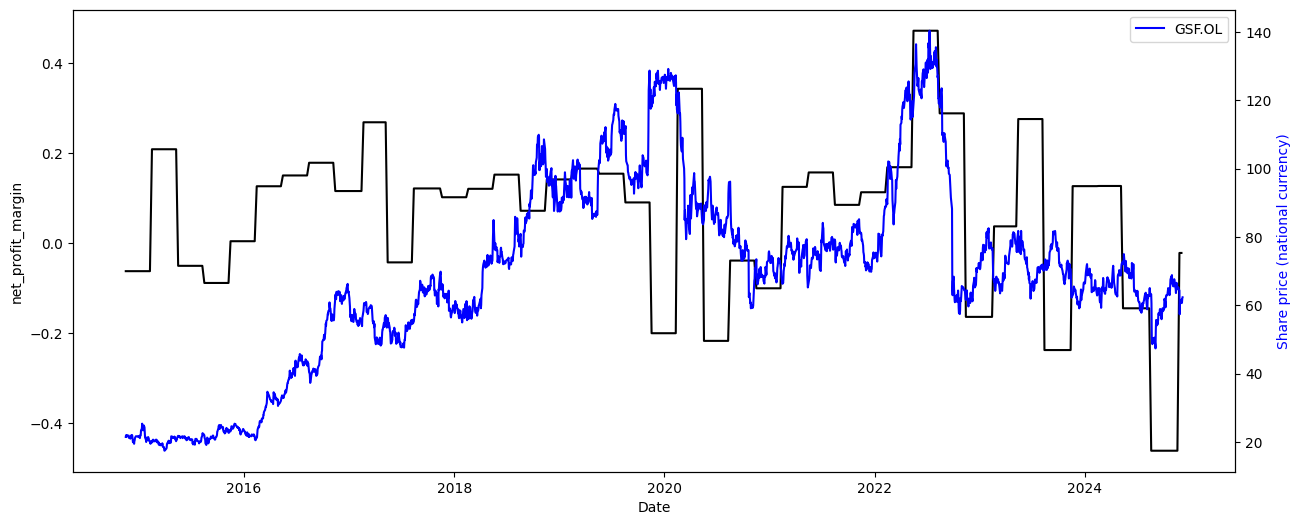

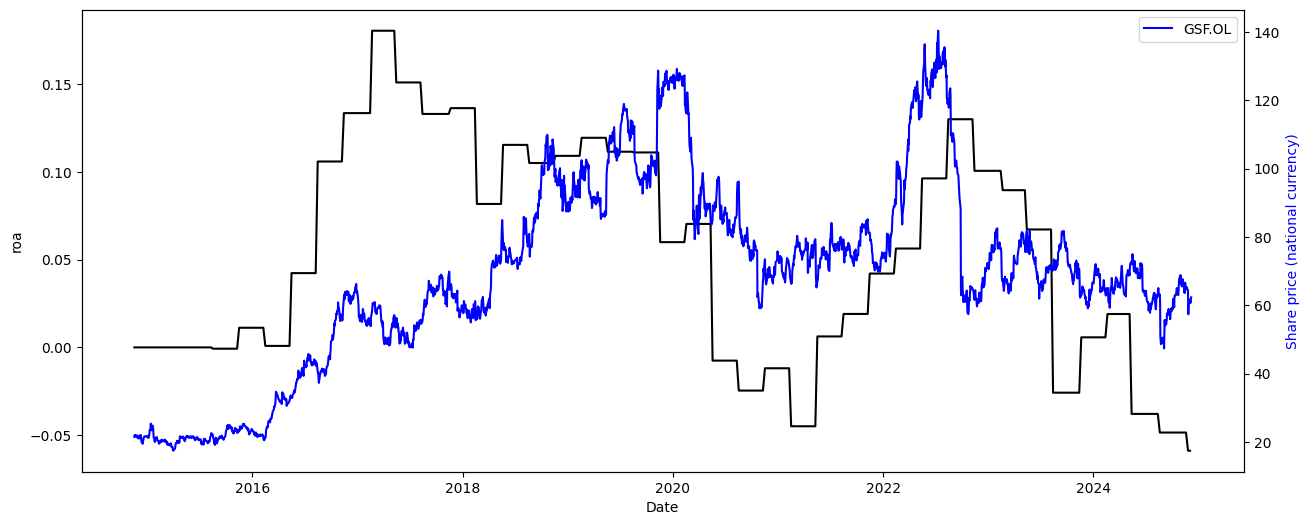

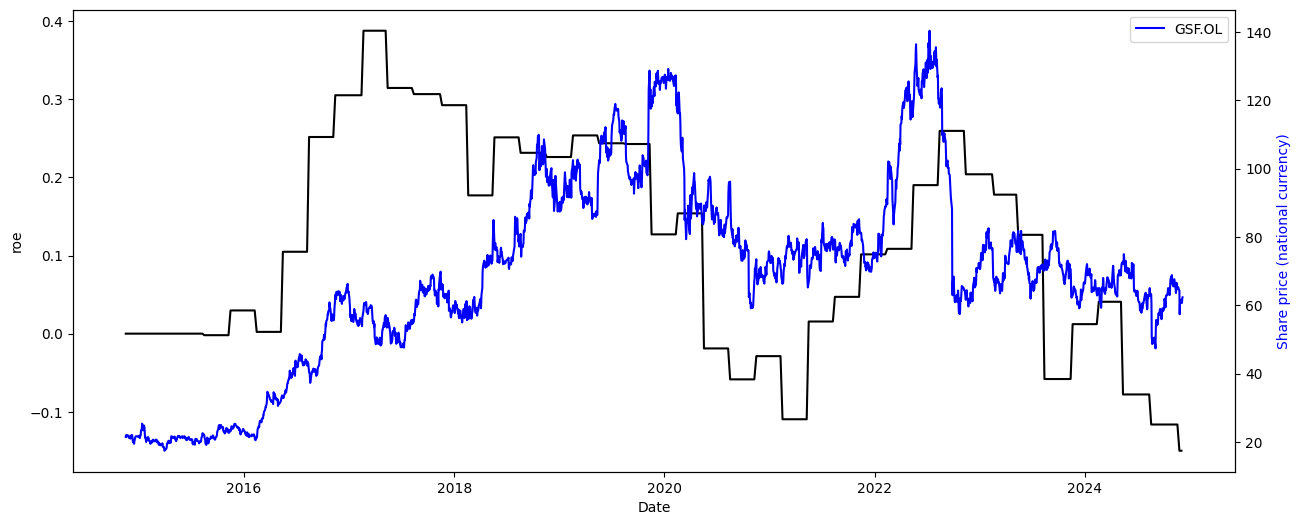

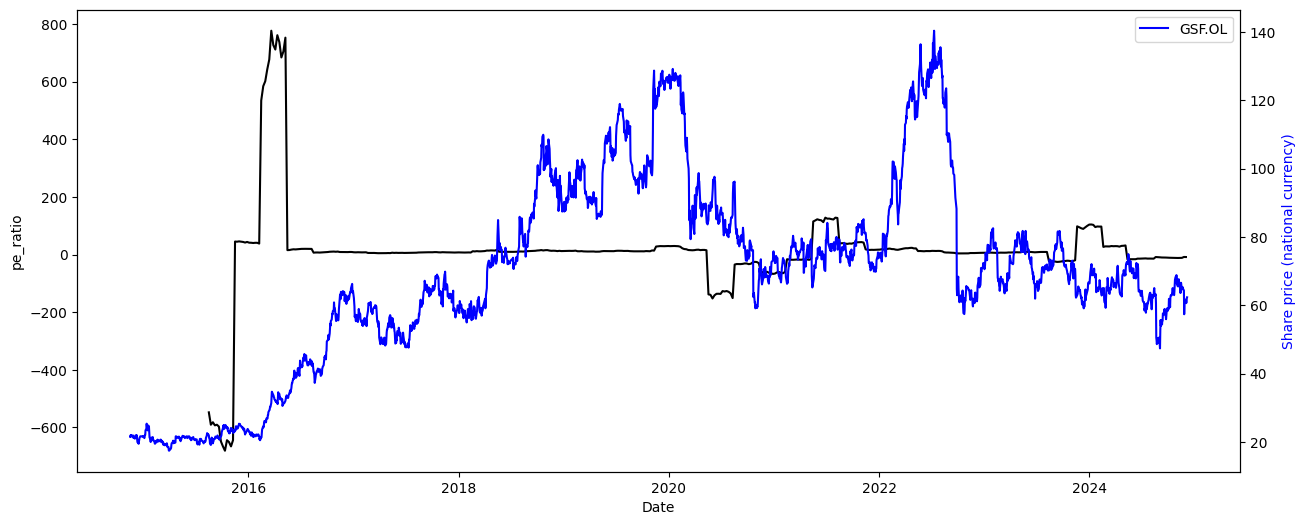

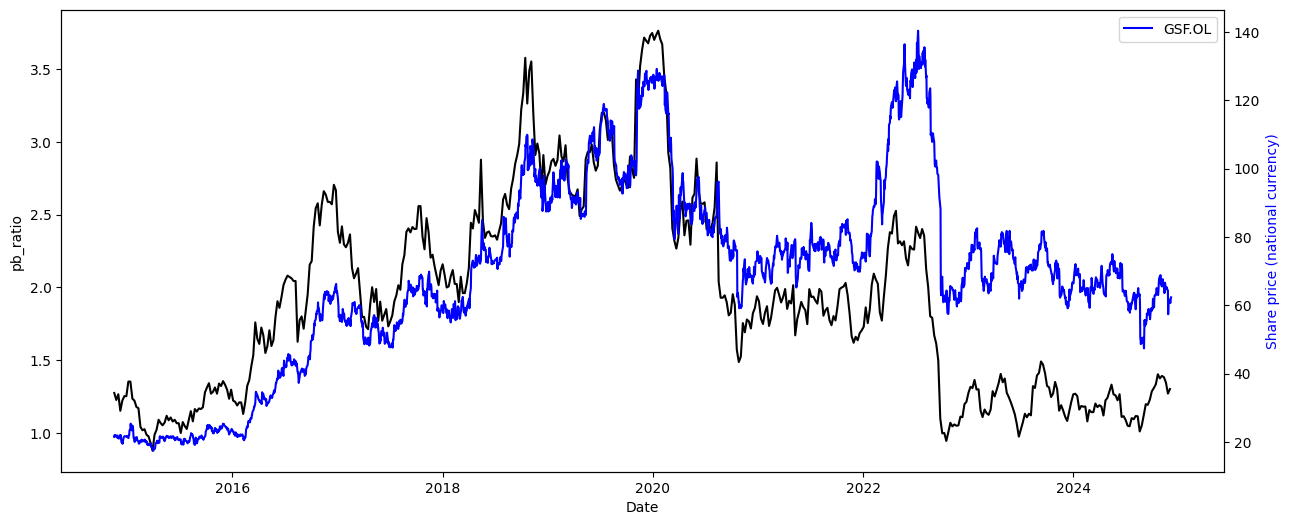

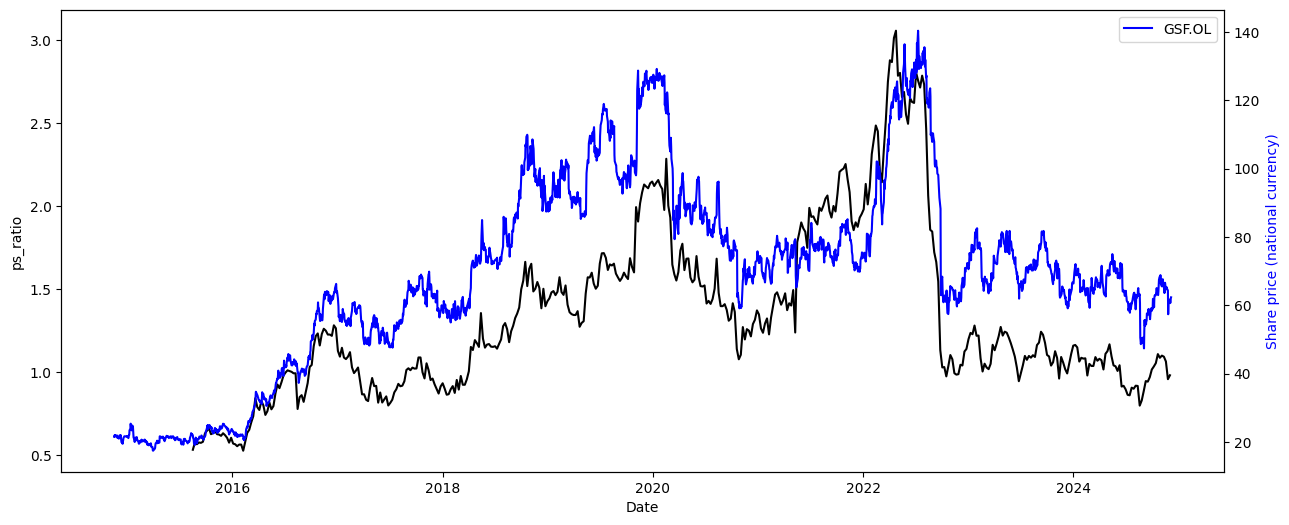

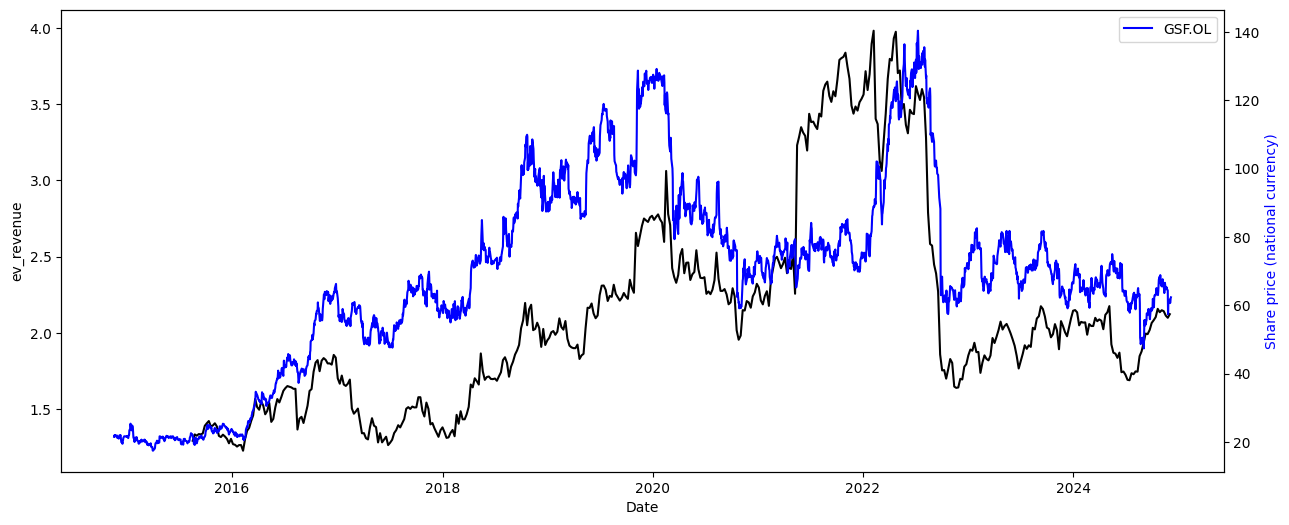

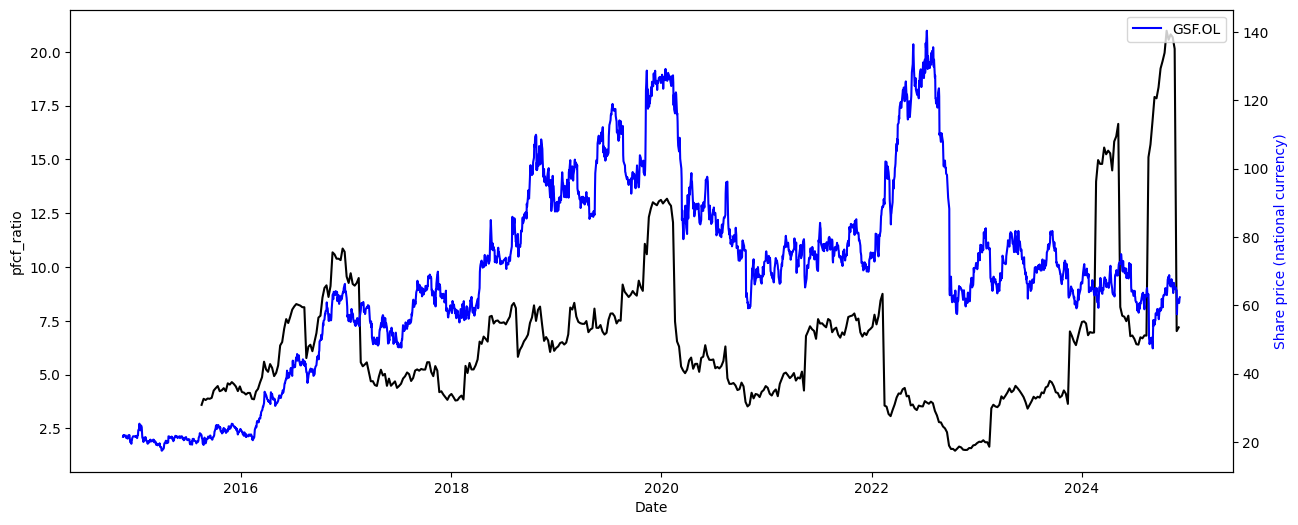

In [18]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

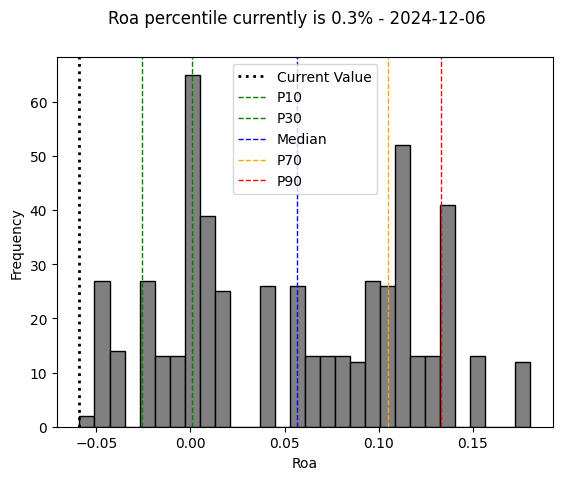

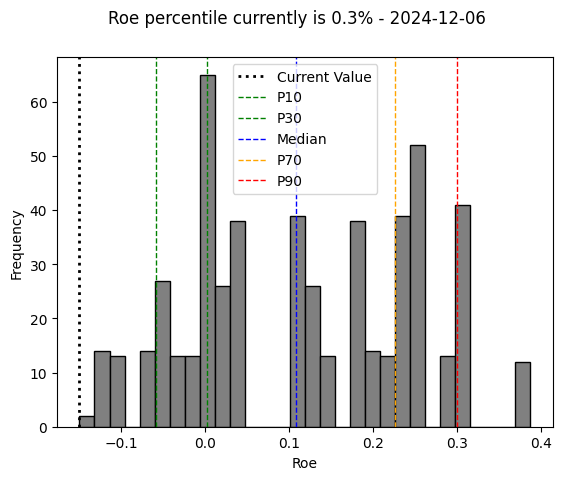

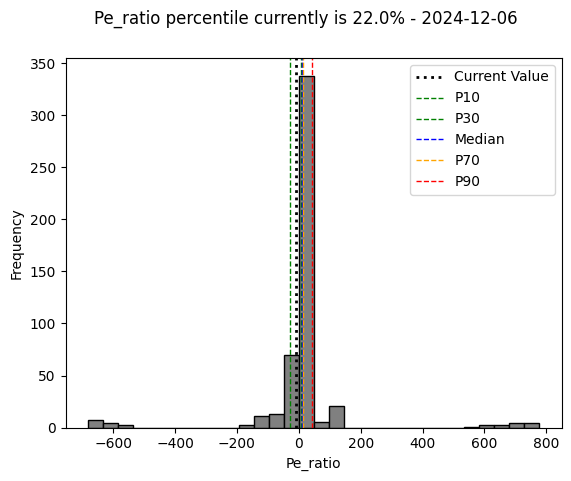

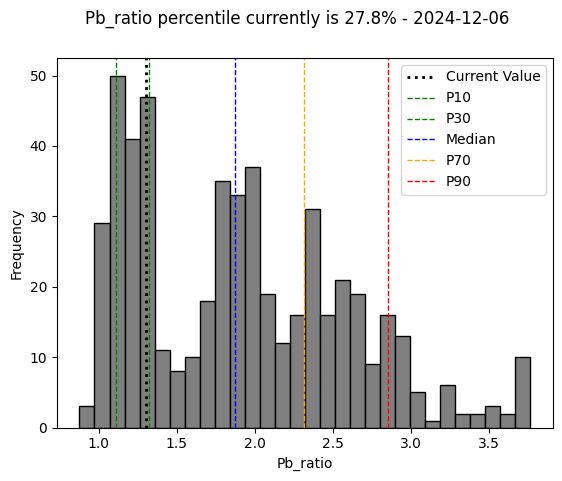

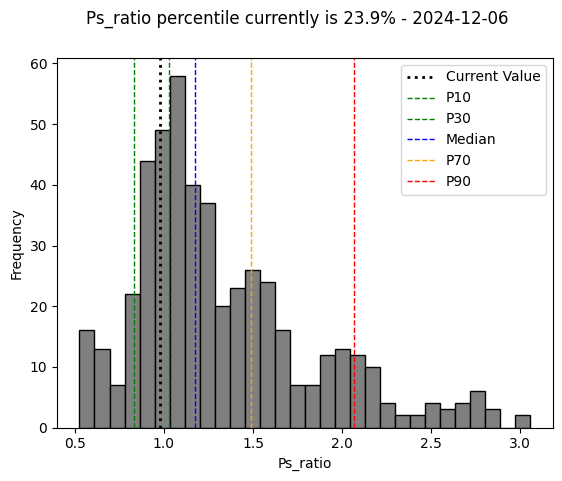

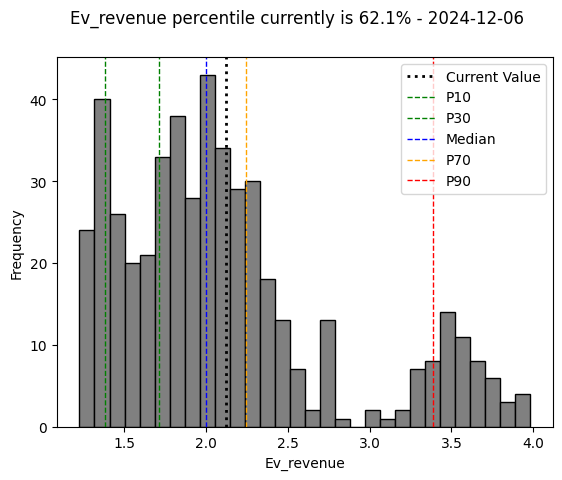

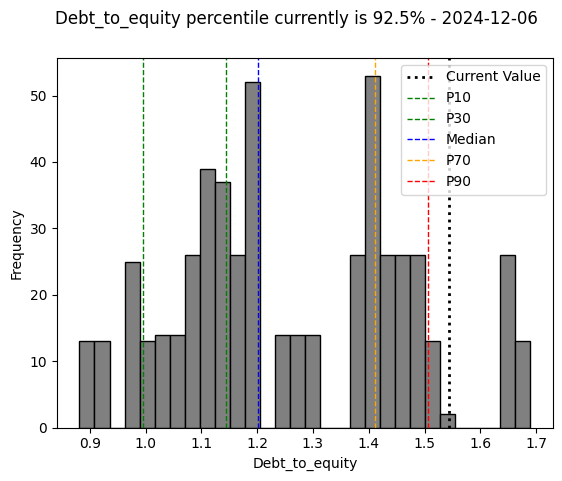

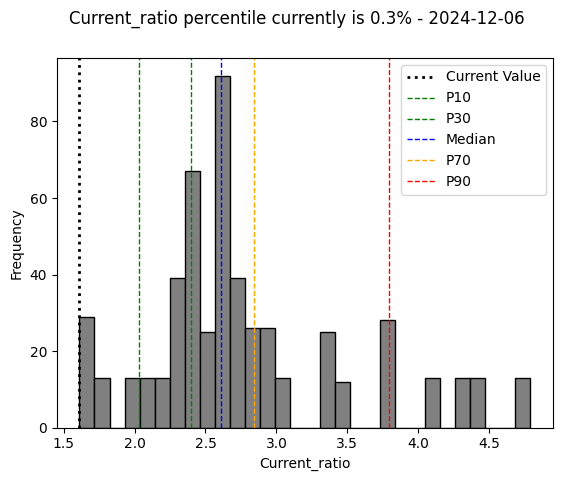

In [19]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [20]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.997327,0.033957,0.479288,0.049398,-0.227100,-0.540233,0.230642
roe,0.997327,1.000000,0.037053,0.492280,0.035128,-0.237134,-0.502042,0.193034
pe_ratio,0.033957,0.037053,1.000000,0.033071,0.050645,0.051782,0.008578,0.098229
pb_ratio,0.479288,0.492280,0.033071,1.000000,0.498511,0.226349,-0.177072,-0.013986
ps_ratio,0.049398,0.035128,0.050645,0.498511,1.000000,0.921700,-0.281227,0.409905
ev_revenue,-0.227100,-0.237134,0.051782,0.226349,0.921700,1.000000,-0.081619,0.294082
debt_to_equity,-0.540233,-0.502042,0.008578,-0.177072,-0.281227,-0.081619,1.000000,-0.714622
current_ratio,0.230642,0.193034,0.098229,-0.013986,0.409905,0.294082,-0.714622,1.000000


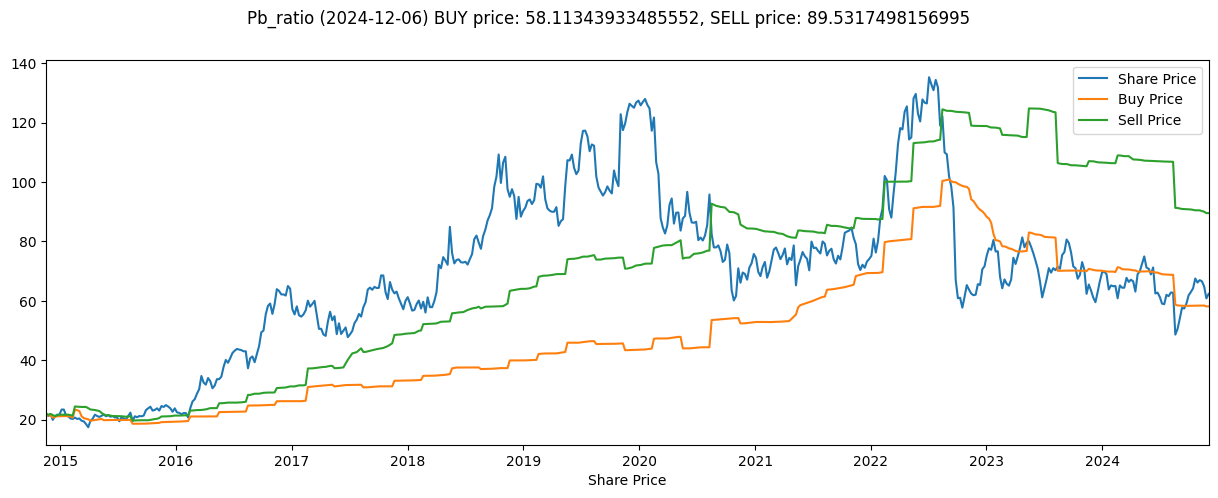

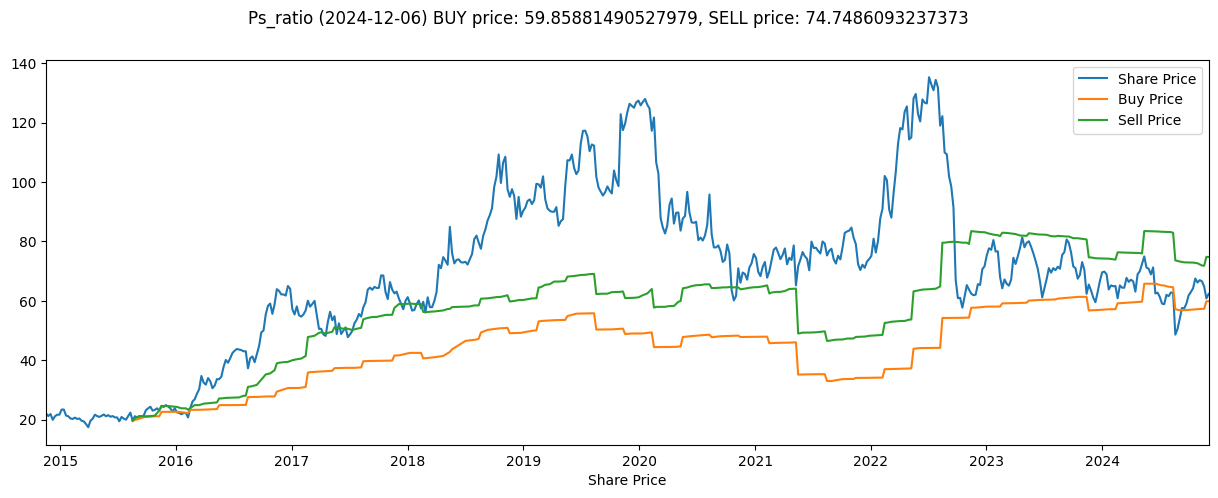

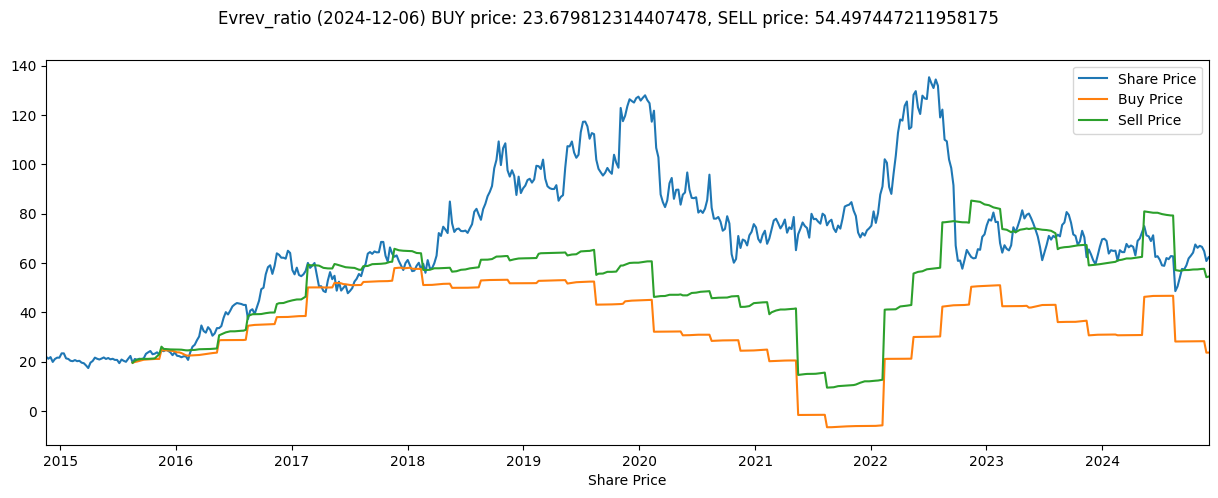

In [21]:
final_df = utils.get_value_stock_target_prices(
    input_df=merged_nat_curr,
    min_pct=0.2,
    max_pct=0.5,
    owned_shares=owned_shares
)